In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values


In [6]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)
static_sd = df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values


In [7]:
from sklearn.model_selection import train_test_split, KFold

In [8]:
n_splits = 10


In [9]:
from common import compute_rmse

In [10]:
np.arange(0.1, 1.0, 0.1)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [30]:
pred = {}
sd = {}
out = {}
n_splits = 10
NUM_RANDOM = 3
n_iter=1200
TRAIN_SPLITS = range(10, 110, 40)
case = 2
num_season=2

cost = 'l21'
algo = 'adagrad'
for static_fac in [None]:
    if static_fac is None:
        H_known_Sd = None
    else:
        H_known_Sd = static_sd    
    np.random.seed(0)
    pred[static_fac] = {}
    #for lam in [1e-3, 1e-2, 1e-1, 0, 1]:
    for lam in [0]:
        pred[static_fac][lam] = {}
        for a in range(2, 10):

            pred[static_fac][lam][a] = {}
            for random_seed in range(NUM_RANDOM):
                pred[static_fac][lam][a][random_seed] = {}
                for appliance in APPLIANCES_ORDER:
                    pred[static_fac][lam][a][random_seed][appliance] = {f:[] for f in TRAIN_SPLITS}

            kf = KFold(n_splits=n_splits)
            for random_seed in range(NUM_RANDOM):

                for train_percentage in TRAIN_SPLITS:
                    print(lam, static_fac, a, random_seed,train_percentage)
                    for train_max, test in kf.split(df):

                        num_train = int((train_percentage*len(train_max)/100)+0.5)
                        if train_percentage==100:
                            train = train_max
                        else:
                            train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
                        train_ix = df.index[train]
                        test_ix = df.index[test]

                        num_test = len(test_ix)
                        train_test_ix = np.concatenate([test_ix, train_ix])
                        df_t, dfc_t = df.ix[train_test_ix], dfc.ix[train_test_ix]
                        tensor = get_tensor(df_t, dfc_t)
                        tensor_copy = tensor.copy()
                        # First n
                        tensor_copy[:num_test, 1:, :] = np.NaN
                        if static_fac is not None:
                            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, num_season, num_iter=n_iter, lr=1, dis=False, cost_function=cost, H_known=H_known_Sd[np.concatenate([test, train])], penalty_coeff=lam)
                        else:
                            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy,  a, num_season, num_iter=n_iter, lr=1, dis=False, cost_function=cost, penalty_coeff=lam)

                        HAT = multiply_case(H, A, T, case)
                        for appliance in APPLIANCES_ORDER:
                            pred[static_fac][lam][a][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


(0, None, 2, 0, 10)
(0, None, 2, 0, 50)
(0, None, 2, 0, 90)
(0, None, 2, 1, 10)
(0, None, 2, 1, 50)
(0, None, 2, 1, 90)
(0, None, 2, 2, 10)
(0, None, 2, 2, 50)
(0, None, 2, 2, 90)
(0, None, 3, 0, 10)
(0, None, 3, 0, 50)
(0, None, 3, 0, 90)
(0, None, 3, 1, 10)
(0, None, 3, 1, 50)
(0, None, 3, 1, 90)
(0, None, 3, 2, 10)
(0, None, 3, 2, 50)
(0, None, 3, 2, 90)
(0, None, 4, 0, 10)
(0, None, 4, 0, 50)
(0, None, 4, 0, 90)
(0, None, 4, 1, 10)
(0, None, 4, 1, 50)
(0, None, 4, 1, 90)
(0, None, 4, 2, 10)
(0, None, 4, 2, 50)
(0, None, 4, 2, 90)
(0, None, 5, 0, 10)
(0, None, 5, 0, 50)
(0, None, 5, 0, 90)
(0, None, 5, 1, 10)
(0, None, 5, 1, 50)
(0, None, 5, 1, 90)
(0, None, 5, 2, 10)
(0, None, 5, 2, 50)
(0, None, 5, 2, 90)
(0, None, 6, 0, 10)
(0, None, 6, 0, 50)
(0, None, 6, 0, 90)
(0, None, 6, 1, 10)
(0, None, 6, 1, 50)
(0, None, 6, 1, 90)
(0, None, 6, 2, 10)
(0, None, 6, 2, 50)
(0, None, 6, 2, 90)
(0, None, 7, 0, 10)
(0, None, 7, 0, 50)
(0, None, 7, 0, 90)
(0, None, 7, 1, 10)
(0, None, 7, 1, 50)


In [32]:
from common import compute_rmse_fraction

In [34]:
out = {}
algo = 'adagrad'
for static_fac in [None]:
    out[static_fac] = {}
    #for lam in [1e-3, 1e-2, 1e-1, 0, 1]:
    for lam in [0]:    
        out[static_fac][lam] = {}
        for a in range(2, 10):
            out[static_fac][lam][a] = {}
            for random_seed in range(NUM_RANDOM):
                out[static_fac][lam][a][random_seed] = {}

                for appliance in APPLIANCES_ORDER[1:]:
                    out[static_fac][lam][a][random_seed][appliance] = {}
                    for f in TRAIN_SPLITS:
                        s = pd.concat(pred[static_fac][lam][a][random_seed][appliance][f]).loc[df.index]
                        if appliance=="hvac":
                            out[static_fac][lam][a][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                        else:   
                            out[static_fac][lam][a][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

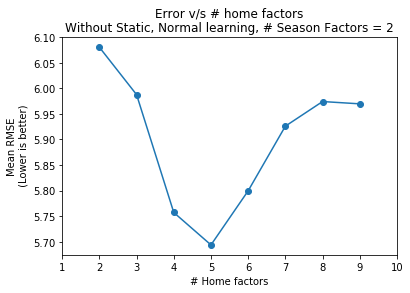

In [51]:
mean_error = {}
for a in range(2, 10):
    mean_error[a] =  pd.Panel(out[None][lam][a]).mean(axis=0).mean().mean()
pd.Series(mean_error).plot(marker='o')
plt.xlabel("# Home factors")
plt.ylabel("Mean RMSE\n (Lower is better)")
plt.xlim((1, 10))
plt.title("Error v/s # home factors\nWithout Static, Normal learning, # Season Factors = 2")

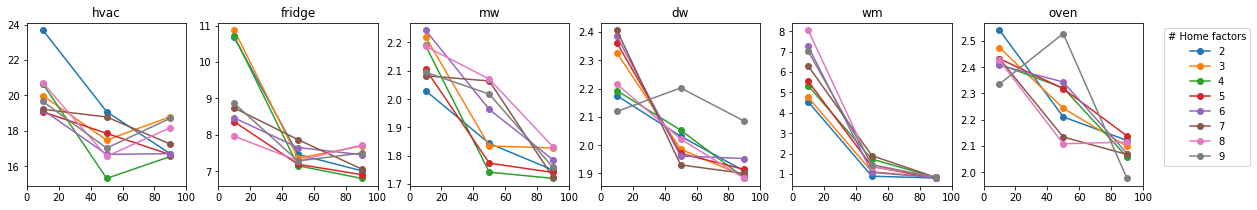

In [61]:
fig, ax = plt.subplots(ncols=6, figsize=(20, 3))
for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
    for a in range(2, 10):
        pd.Panel(out[None][lam][a]).mean(axis=0)[appliance].plot(ax=ax[i], label=a, marker='o', title=appliance)
    ax[i].set_xlim((0, 100))
plt.legend(bbox_to_anchor=(1.1, 1), title='# Home factors')

In [80]:
c = {}
for col in ['area', 'num_rooms', 'total_occupants', ]:
    c[col] = len( df[col].dropna())
c
c['all'] = len(df[['area', 'num_rooms', 'total_occupants', ]].dropna())
c

{'all': 8, 'area': 23, 'num_rooms': 9, 'total_occupants': 8}

In [81]:
len(df)

39

In [42]:
import pickle
pickle.dump(out, open('predictions/normal-sparse-static-normalised.pkl','w'))

5.66048651687
6.06131971708
6.28308213805
6.58586505733
5.6711170383


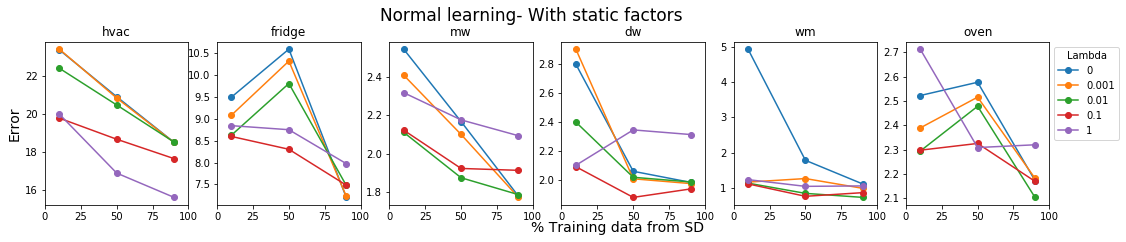

In [43]:
static_res = {}
fig, ax = plt.subplots(ncols=6, figsize=(18, 3))

for lam in [0, 1e-3, 1e-2, 1e-1, 1]:
    static_res[lam] = pd.Panel(out['static'][lam][2]).mean(axis=0)
    for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
        static_res[lam][appliance].plot(ax=ax[i], marker='o', title=appliance)
        ax[i].set_xlim((0, 100))
plt.legend([0, 1e-3, 1e-2, 1e-1, 1], bbox_to_anchor=(1, 1), title='Lambda')
fig.text(0.5, 0, "% Training data from SD", fontsize=14)
ax[0].set_ylabel("Error", fontsize=14)

print static_res[0.1].mean().mean()
print static_res[0.01].mean().mean()
print static_res[0.001].mean().mean()
print static_res[0.0].mean().mean()
print static_res[1].mean().mean()
plt.suptitle("Normal learning- With static factors", fontsize=17,y=1.04)


5.29569115205
5.29331341176
5.40300182878
5.69381795578
5.50673501027


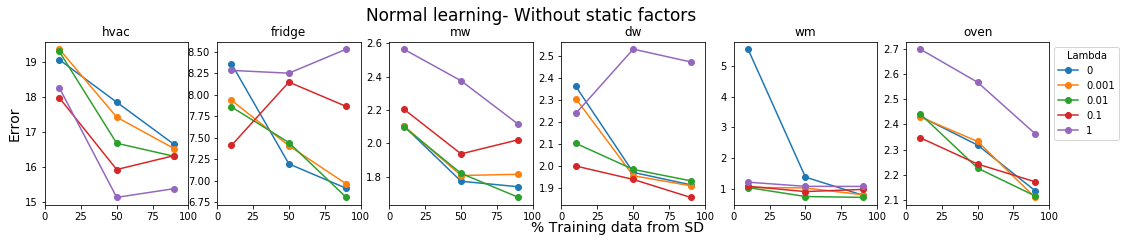

In [44]:
static_res = {}
fig, ax = plt.subplots(ncols=6, figsize=(18, 3))

for lam in [0, 1e-3, 1e-2, 1e-1, 1]:
    static_res[lam] = pd.Panel(out[None][lam][2]).mean(axis=0)
    for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
        static_res[lam][appliance].plot(ax=ax[i], marker='o', title=appliance)
        ax[i].set_xlim((0, 100))
plt.legend([0, 1e-3, 1e-2, 1e-1, 1], bbox_to_anchor=(1, 1), title='Lambda')
fig.text(0.5, 0, "% Training data from SD", fontsize=14)
ax[0].set_ylabel("Error", fontsize=14)
plt.suptitle("Normal learning- Without static factors", fontsize=17,y=1.04)

print static_res[0.1].mean().mean()
print static_res[0.01].mean().mean()
print static_res[0.001].mean().mean()
print static_res[0.0].mean().mean()
print static_res[1].mean().mean()


In [45]:
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, H_known=H_known_Sd[np.concatenate([test, train])], penalty_coeff=lam)


TypeError: 'NoneType' object has no attribute '__getitem__'

(0, 0)
(1, 0.001)
(2, 0.01)
(3, 0.1)
(4, 1)
(5, 2)


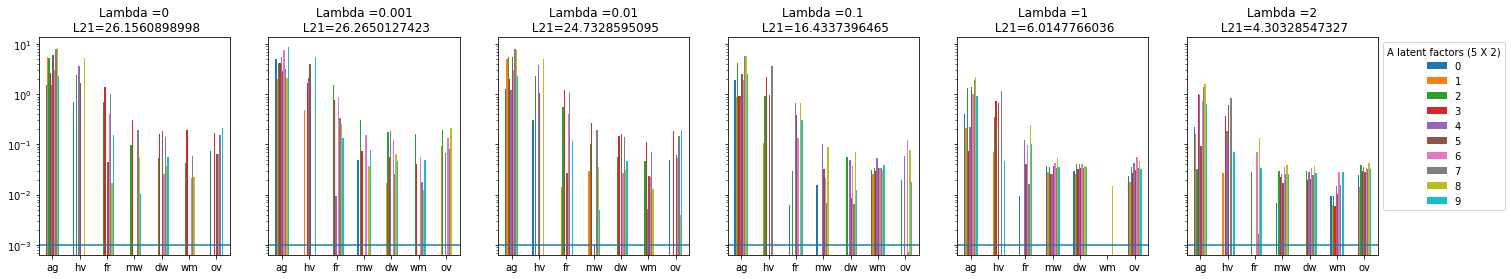

In [112]:
fig, ax = plt.subplots(ncols=6, figsize=(24, 4), sharey=True)
for i, lam in enumerate([0, 1e-3, 1e-2, 1e-1, 1, 2]):
    print(i, lam)
    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case,tensor_copy,num_home, a,
                                                         num_iter=1000, lr=1, dis=False, 
                                                         cost_function=cost, 
                                                         H_known=static_sd[np.concatenate([test, train])], 
                                                         penalty_coeff=lam)
    A[A<1e-7] = 0
    A_shape = A.shape
    A_flat = A.reshape(A_shape[0], A_shape[1]*A_shape[2])
    l1 = 0.
    for j in range(A_shape[0]):
        l1 = l1 + np.sqrt(np.square(A_flat[j,:]).sum())
    pd.DataFrame(A.reshape(7, 10), index=[x[:2] for x in APPLIANCES_ORDER]).plot(kind='bar', rot=0, 
                                                                ax=ax[i], 
                                                                title="Lambda ={}\n L21={}".format(lam, l1)
                                                               ,legend=False, logy=True)
    ax[i].axhline(1e-3)
ax[i].legend(title='A latent factors (5 X 2)',bbox_to_anchor=(1, 1))


(0, 0)
(1, 0.001)
(2, 0.01)
(3, 0.1)
(4, 1)
(5, 2)


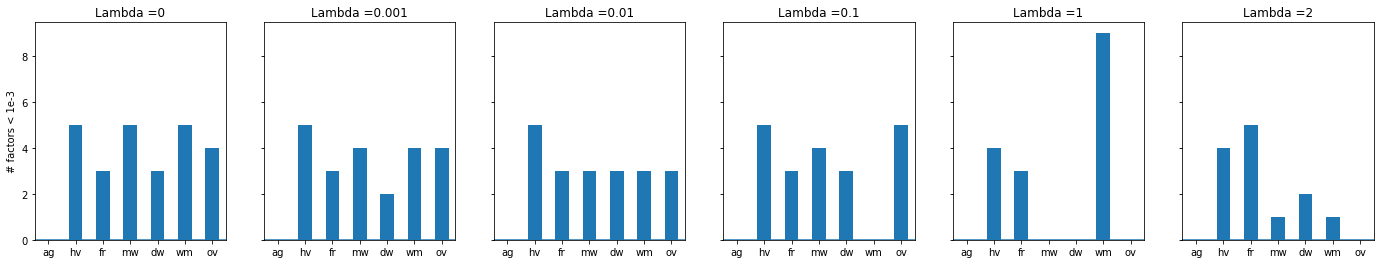

In [114]:
fig, ax = plt.subplots(ncols=6, figsize=(24, 4), sharey=True)
for i, lam in enumerate([0, 1e-3, 1e-2, 1e-1, 1, 2]):
    print(i, lam)
    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case,tensor_copy,num_home, a,
                                                         num_iter=1000, lr=1, dis=False, 
                                                         cost_function=cost, 
                                                         H_known=static_sd[np.concatenate([test, train])], 
                                                         penalty_coeff=lam)
    A[A<1e-7] = 0
    pd.Series(np.sum(A<1e-3, axis=1).sum(axis=1), index=[x[:2] for x in APPLIANCES_ORDER]).plot(kind='bar', rot=0, 
                                                                ax=ax[i], 
                                                                title="Lambda ={}".format(lam)
                                                               ,legend=False)
    ax[i].axhline(1e-3)
ax[0].set_ylabel('# factors < 1e-3')


In [115]:
static

NameError: name 'static' is not defined

(0, 0)
(1, 0.001)
(2, 0.01)
(3, 0.1)
(4, 1)


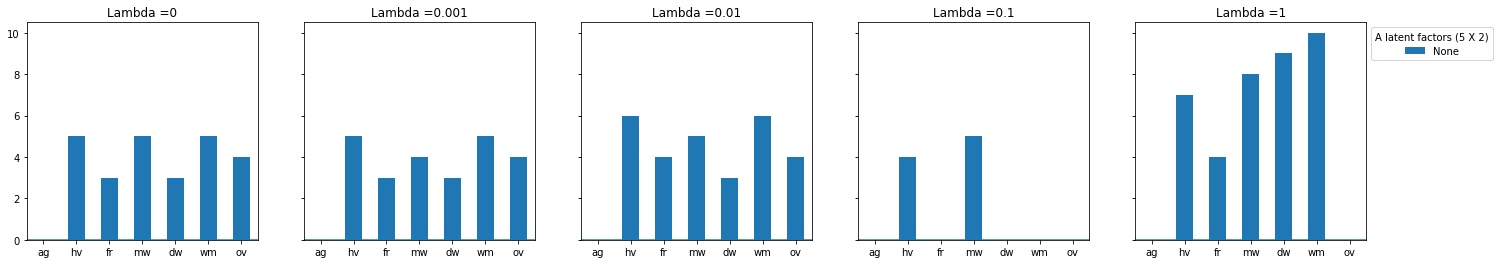

In [108]:
fig, ax = plt.subplots(ncols=5, figsize=(24, 4), sharey=True)
for i, lam in enumerate([0, 1e-3, 1e-2, 1e-1, 1]):
    print(i, lam)
    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case,tensor_copy,num_home, a,
                                                         num_iter=1000, lr=1, dis=False, 
                                                         cost_function='l12', 
                                                         H_known=static_sd[np.concatenate([test, train])], 
                                                         penalty_coeff=lam)
    A[A<1e-7] = 0
    pd.Series(np.sum(A<1e-3, axis=1).sum(axis=1), index=[x[:2] for x in APPLIANCES_ORDER]).plot(kind='bar', rot=0, 
                                                                ax=ax[i], 
                                                                title="Lambda ={}".format(lam)
                                                               ,legend=False)
    ax[i].axhline(1e-3)
ax[i].legend(title='A latent factors (5 X 2)',bbox_to_anchor=(1, 1))


In [105]:
np.sum(A<1e-3, axis=1).sum(axis=1)

array([0, 4, 3, 0, 0, 9, 0])

In [116]:
static_fac